---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: false
---

# Understanding Real Estate Prices

I now want to see whether the regions that are experiencing the most loss of greenery are the ones that urbanizing the fastest. Kathmandu's sprawl has been rapidly increasing in recent years, with empty land almost impossible find in the city center. If someone wants to build or even buy a house at an affordable price, they will need to find a plot in the edges of the city. Hence, my assumption goes that areas that are urbanizing the fastest will have the most listings in real estate websites. 

For this part of the analysis, i want to gather information on the distribution of real estate listings across the city.

## Scraping Web Data
There is no public information on real estate values across Kathmandu—for this I will need to scrape listings from popular real estate websites and put together my own dataset. In this section, i will execute a script that gathers listing information from Nepal Homes, a popular online real estate marketplace.

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.by import By
import pandas as pd
import time
from time import sleep

driver = webdriver.Chrome()

url = "https://www.nepalhomes.com/search?find_property_category=5d660cb27682d03f547a6c4a"
driver.get(url)

propertySoup = BeautifulSoup(driver.page_source, "html.parser")

element = propertySoup.select("div.property__card")

max_pages = 30
base_url = "https://www.nepalhomes.com/search?find_property_category=5d660cb27682d03f547a6c4a"
results = []

for page_num in range(1, max_pages + 1):
    print(f"Processing page {page_num}...")

    # Update the URL hash for this page number and make the combined URL
    url_hash = f"#search={page_num}~gallery~0~0"
    url = base_url + url_hash

    # Go to the driver and wait for 5 seconds
    driver.get(url)
    sleep(5)

    # Get the page source and parse it
    soup = BeautifulSoup(driver.page_source, "html.parser")
    apts = soup.select("div.property__card")
    print("Number of apartments = ", len(apts))

    # Process properties on this page
    page_results = []
    for apt in apts:  # Changed from element to apts
        # Extract price
        price_elem = apt.select_one('span.price-tag')
        price = price_elem.text.strip() if price_elem else None

        # Extract location
        location_elem = apt.select_one('p.property__card-location')
        location = location_elem.text.strip() if location_elem else None

        # Extract specs (road access, facing, floors)
        specs = apt.select('div.spec-item p')
        specifications = [spec.text.strip() for spec in specs]
        road_access = specifications[0] if specifications else None

        # Extract title
        title_elem = apt.select_one('h3.property__card-title')
        title = title_elem.text.strip() if title_elem else None

        # Extract property type
        type_elem = apt.select_one('span.search_property_category_tag')
        property_type = type_elem.text.strip() if type_elem else None

        # Extract status (rent/sale)
        status_elem = apt.select_one('span.card-stat')
        status = status_elem.text.strip() if status_elem else None

        # Save the result
        page_results.append([price, location, road_access, title, property_type, status])

    # Create a dataframe for this page
    col_names = ["price", "location", "road_access", "title", "property_type", "status"]
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)

    if page_num < max_pages:
        print("sleeping for 10 seconds between pages")
        sleep(10)

# Finally, concatenate all the results
final_results = pd.concat(results, axis=0).reset_index(drop=True)

# Save to CSV
final_results.to_csv('nepal_properties.csv', index=False)
print(f"Total properties scraped: {len(final_results)}")

Processing page 1...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 2...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 3...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 4...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 5...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 6...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 7...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 8...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 9...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 10...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 11...
Number of apartments =  8
sleeping for 10 seconds between pages
Processing page 12...
Number of apartments =  8
sleeping for 10

Great! Our data is ready. Lets see how it looks like.

In [2]:
final_results.head()

,price,location,road_access,title,property_type,status
0,Rs. 2.7 Cr,"Imadol, Lalitpur",3.2 aana,House for Sale,House,Sale
1,Rs. 2 Lac/m,"Chhetrapati, Kathmandu",12 Feet,House for Rent,House,Rent
2,Rs. 1.5 Lac/m,"Baluwatar, Kathmandu",18 Feet,House for Rent,House,Rent
3,Rs. 1 Lac/m,"Kalanki, Kathmandu",13 Feet,House for Rent,House,Rent
4,"Rs. 65,000 /m","Jawalakhel, Lalitpur",18 Feet,House for Rent,House,Rent


This data looks very messy. We need to standardize these varianbles. Lets do some data cleaning. This entire process was built from iterative cleaning with chat GPT.

In [13]:
def standardize_price(price):
    """
    Convert all prices to annual amount in rupees:
    - Cr (Crore) -> multiply by 10,000,000
    - Lac/m (Lakh per month) -> multiply by 100,000 * 12 (for annual)
    - /m (per month) -> multiply by 12 (for annual)
    - /y (per year) -> keep as is
    """
    price = str(price).strip().replace('Rs. ', '').replace(',', '')
    
    if 'Cr' in price:
        value = float(price.replace(' Cr', '')) * 10000000
    elif 'Lac/m' in price:
        # Convert to annual
        value = float(price.replace(' Lac/m', '')) * 100000 * 12
    elif '/m' in price:
        # Convert to annual
        value = float(price.replace(' /m', '')) * 12
    elif '/y' in price:
        value = float(price.replace(' /y', ''))
    else:
        value = float(price)
    
    return value

def standardize_location(location):
    """Split location into city and district, and standardize names"""
    city, district = location.split(', ')
    
    # Standardize district names (all are either Kathmandu or Lalitpur)
    district = district.strip().title()
    
    # Standardize city names (first letter capital)
    city = city.strip().title()
    
    return pd.Series([city, district], index=['city', 'district'])

def standardize_road_access(access):
    """
    Standardize road access:
    - Convert all measurements to feet
    - 1 aana = approximately 342.25 square feet
    """
    access = str(access).strip()
    if 'aana' in access:
        value = float(access.replace(' aana', '')) * 342.25
        return f"{value:.2f} sq. feet"
    elif 'Feet' in access:
        value = float(access.replace(' Feet', ''))
        return f"{value:.0f} feet"
    return access

def standardize_title(title):
    """Standardize title cases"""
    return title.strip().title()

def standardize_status(status):
    """Standardize status to consistent capitalization"""
    return status.strip().title()

def clean_dataframe(df):
    """Apply all standardization functions to the dataframe"""
    df_clean = df.copy()
    
    # Apply standardizations
    df_clean['price_numeric'] = df_clean['price'].apply(standardize_price)
    df_clean[['city', 'district']] = df_clean['location'].apply(standardize_location)
    df_clean['road_access_std'] = df_clean['road_access'].apply(standardize_road_access)
    df_clean['title'] = df_clean['title'].apply(standardize_title)
    df_clean['status'] = df_clean['status'].apply(standardize_status)
    
    # Add price type column to indicate original price type (sale vs rental)
    df_clean['price_type'] = df_clean['price'].apply(
        lambda x: 'Sale Price' if 'Cr' in x else 'Annual Rent'
    )
    
    # Reorder and select final columns
    final_columns = [
        'title', 'city', 'district', 'price_numeric', 'price_type',
        'road_access_std', 'status', 'property_type'
    ]
    
    return df_clean[final_columns]

# Usage:
cleanprices = clean_dataframe(final_results)

In [14]:
cleanprices.head()

,title,city,district,price_numeric,price_type,road_access_std,status,property_type
0,House For Sale,Imadol,Lalitpur,27000000.0,Sale Price,1095.20 sq. feet,Sale,House
1,House For Rent,Chhetrapati,Kathmandu,2400000.0,Annual Rent,12 feet,Rent,House
2,House For Rent,Baluwatar,Kathmandu,1800000.0,Annual Rent,18 feet,Rent,House
3,House For Rent,Kalanki,Kathmandu,1200000.0,Annual Rent,13 feet,Rent,House
4,House For Rent,Jawalakhel,Lalitpur,780000.0,Annual Rent,18 feet,Rent,House


That looks a lot better! Now lets plot the average prices of houses for each city.

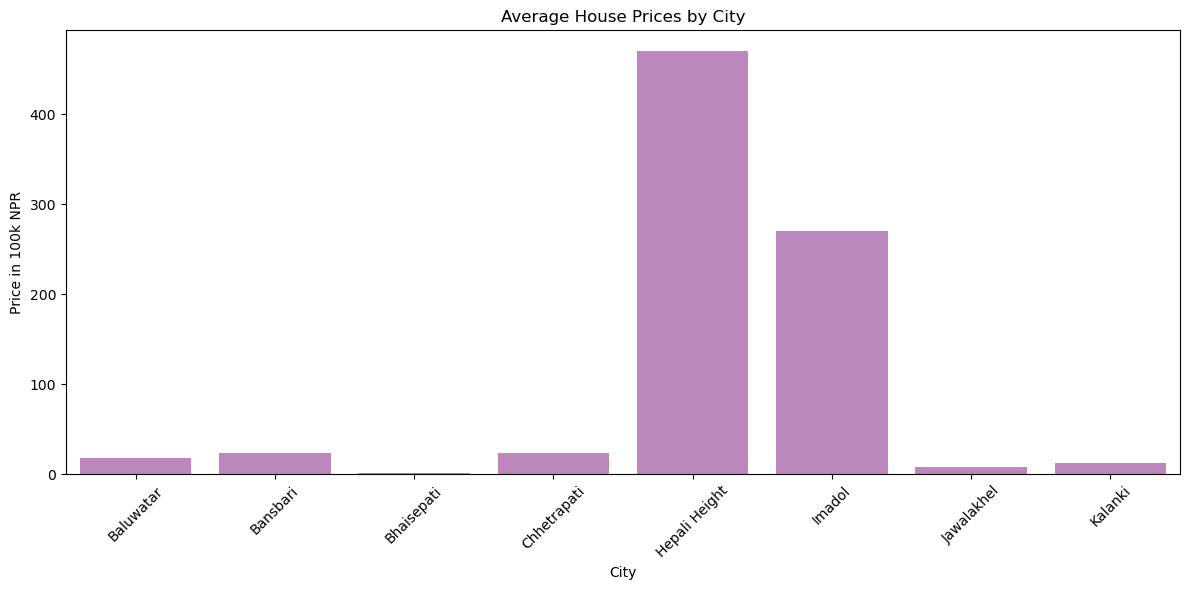

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plot1 = cleanprices.groupby('city')['price_numeric'].mean().reset_index()
plot1['price_numeric'] = (plot1['price_numeric']/100000).round(1)

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot1, x='city', y='price_numeric', alpha=0.5, color='darkmagenta', label='Mean')

plt.title('Average House Prices by City')
plt.xlabel('City')
plt.ylabel('Price in 100k NPR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
